In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import json
%matplotlib inline

pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender and was made available [here](https://www.kaggle.com/c/stumbleupon/download/train.tsv)

A description of the columns is below

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonLinkRatio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonLinkRatio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonLinkRatio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonLinkRatio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?
- These are websites that always relevant like recipes or reviews (as opposed to current events)
- Look at some examples

In [4]:
data = pd.read_csv('train.csv', sep='\t', na_values={'is_news' : '?'}).fillna(0)

# Extract the title and body from the boilerplate JSON text
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))

In [5]:
data[['title', 'label']].head()

,title,label
0,"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries",0
1,"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races",1
2,Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health,1
3,10 Foolproof Tips for Better Sleep,1
4,The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen,0


#### Does being a news site effect green-ness?

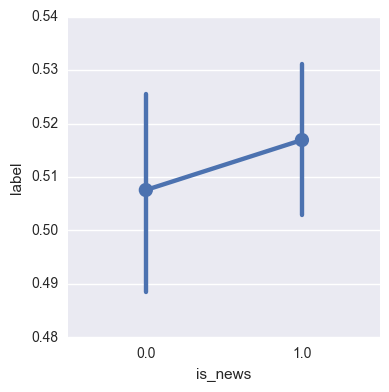

In [7]:
import seaborn as sns

#factorplot from seaborn
sns.factorplot(data=data, x="is_news", y="label")  

#### Does the website category effect green-ness?

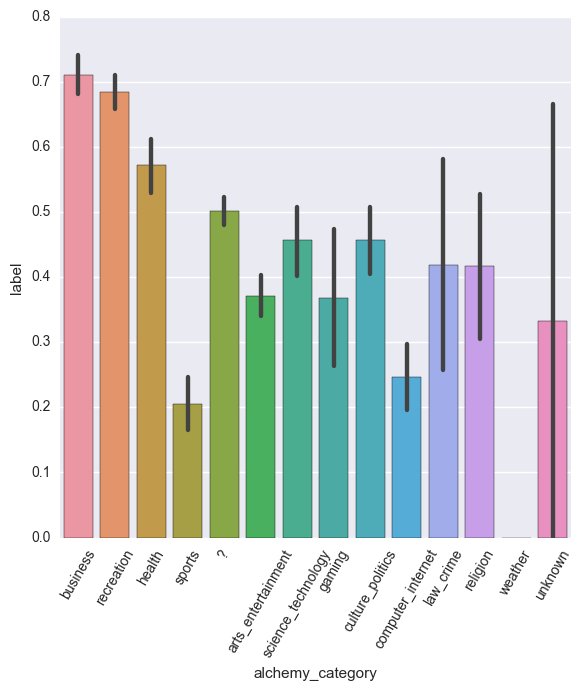

In [20]:
#factorplot from seaborn
p = sns.factorplot(data=data, x="alchemy_category", y="label", size = 6, kind = 'bar') 
p.set_xticklabels(rotation=60)

#### Does the image ratio effect green-ness?

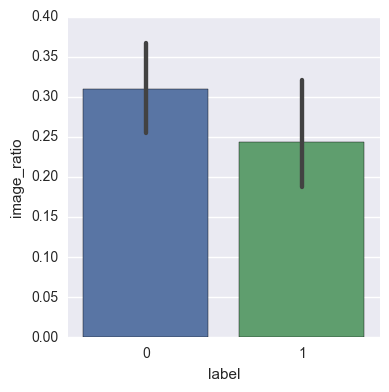

In [22]:
sns.factorplot(data=data, x="label", y="image_ratio", kind = 'bar')  

#### Fit a logistic regression model using statsmodels
- Test different features that may be valuable
- Examine the coefficients, does the feature increase or decrease the effect of being evergreen?

In [28]:
# TODO
import statsmodels.formula.api as sm

data.corr()
#commonlinkratio_3, frameTagRatio, linkwordscore

# model = sm.logit(
#     "label ~ commonlinkratio_3 + frameTagRatio + linkwordscore",
#     data = data
# ).fit() 

# model.summary()

#linkwordscore has a coef close to zero soremove it.
model = sm.logit(
    "label ~ commonlinkratio_3 + frameTagRatio",
    data = data
).fit() 

model.summary()

Optimization terminated successfully.
         Current function value: 0.671881
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7392
Method:                           MLE   Df Model:                            2
Date:                Wed, 26 Oct 2016   Pseudo R-squ.:                 0.03018
Time:                        13:44:24   Log-Likelihood:                -4968.6
converged:                       True   LL-Null:                       -5123.2
                                        LLR p-value:                 6.924e-68
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             0.4375      0.053      8.310      0.000         0.334     0.541
commonlinkratio_3     1.4980      0.264      5.667      0.000         0.980     2.016
frameTagRatio        -9.3549      0.662    -14.123      0.000       -10.653    -8.057
=====================================================================================
"""

#### Fit a logistic regression model using statsmodels with text features
- Add text features that may be useful, add this to the model and see if they improve the fit
- Examine the coefficients, does the feature increase or decrease the effect of being evergreen?

In [41]:
# EXAMPLE text feature 'recipe'
data['is_recipe'] = data['title'].fillna('').str.contains('recipe')
data['is_how_to'] = data['title'].fillna('').str.contains('how to')
data['is_video'] = data['title'].fillna('').str.contains('video')

model = sm.logit(
    "label ~ commonlinkratio_3 + frameTagRatio + is_video + is_how_to + is_recipe",
    data = data
).fit() 

model.summary()

# They have coef that aren't close to zero so I think increase as long as it is the right phrase.

Optimization terminated successfully.
         Current function value: 0.653647
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 7395
Model:                          Logit   Df Residuals:                     7389
Method:                           MLE   Df Model:                            5
Date:                Wed, 26 Oct 2016   Pseudo R-squ.:                 0.05650
Time:                        14:03:41   Log-Likelihood:                -4833.7
converged:                       True   LL-Null:                       -5123.2
                                        LLR p-value:                7.121e-123
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             0.3375      0.054      6.296      0.000         0.232     0.443
is_video[T.True]     -1.2690      0.233     -5.450      0.000        -1.725    -0.813
is_how_to[T.True]     0.6437      0.241      2.670      0.008         0.171     1.116
is_recipe[T.True]     2.0849      0.175     11.936      0.000         1.743     2.427
commonlinkratio_3     1.6637      0.268      6.217      0.000         1.139     2.188
frameTagRatio        -8.9784      0.668    -13.435      0.000       -10.288    -7.669
=====================================================================================
"""